<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk
!pip install nxviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import itertools
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import networkx as nx
import nxviz as nv

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk

True

In [3]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

In [4]:
def clean_df(df):
  df = pd.read_excel(df)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
display(df.head())

,Extract,Notes,Notes2,About Adam Smith,Rep
Date,,,,,
2008-06-10,Democrats will claim this bill will bring gas ...,n/a,n/a,n/a,Mitch McConnell \nRepublican Party
2008-06-12,The sad truth is that the bulk of the EADS tan...,n/a,n/a,n/a,Donald Anthony Manzullo\nRepublican Party
2008-07-10,"The father of modern capitalism, Adam Smith, o...",n/a,n/a,n/a,Joseph Isadore Lieberman\nDemocratic Party
2008-07-15,This gold is not coming back on the market. Su...,n/a,n/a,n/a,Steve King\nRepublican Party
2008-07-23,There are those who will object to the bill be...,n/a,n/a,-‘‘The Wealth of Nations”\n- Those exertions o...,Joseph Isadore Lieberman\nDemocratic Party


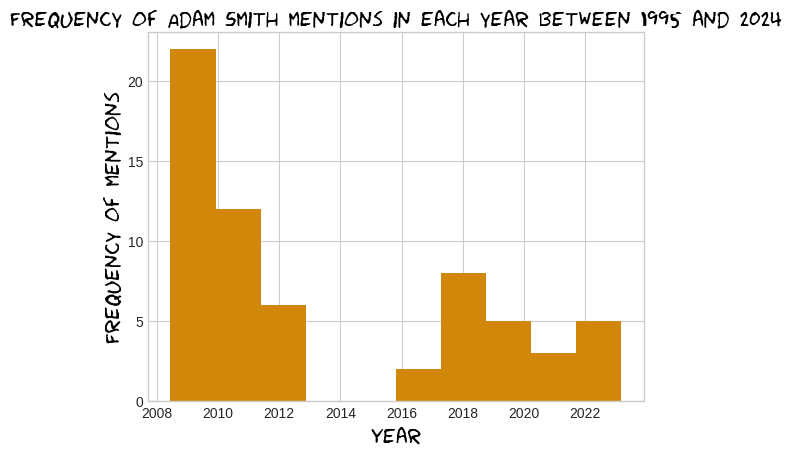

In [5]:
def create_histogram(df):
  #styles 'fast','fivethirtyeight'',',''seaborn-v0_8-whitegrid'
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.hist(df.index, color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Frequency of mentions', fontdict = font)
  plt.title('Frequency of Adam Smith mentions in each year between 1995 and 2024', fontdict = font)
  plt.show()

create_histogram(df)

In [6]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list[0][:10])

['Democrats', 'will', 'claim', 'this', 'bill', 'will', 'bring', 'gas', 'prices', 'down']


In [7]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower() for t in list_of_tokens] for list_of_tokens in list_of_lists for t in list_of_tokens]
  alpha_only = [[t for t in token_list if t.isalpha()] for token_list in lower_tokens]
  no_stops = [[t for t in alpha_list if t not in nltk.corpus.stopwords.words('english')] for alpha_list in alpha_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized

preprocessed = preprocess_tokens(token_list)
print(preprocessed[0][:10])

['democrat', 'claim', 'bill', 'bring', 'gas', 'price', 'counting', 'american', 'forget', 'basic']


In [8]:
def create_corpus(preprocessed_data):
  dictionary = Dictionary(preprocessed)
  corpus = [dictionary.doc2bow(article) for article in preprocessed]
  return dictionary, corpus

dictionary, corpus = create_corpus(preprocessed)
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [9]:
import itertools
from collections import defaultdict
x = [[i[0] for i in j] for j in corpus]

pairs=[list(itertools.combinations(nested_list,2)) for nested_list in x]
catalogue_of_occurences = defaultdict(int)
repeating_pairs = {}
for list_of_pairs in pairs:
  for pair in list_of_pairs:
    catalogue_of_occurences[pair]+=1
y = list(catalogue_of_occurences.keys())
y[0]

(0, 1)

[990, 970, 505, 480, 418, 404, 402, 307, 306, 295, 280, 279, 263, 257, 252, 251, 243, 242, 239, 235, 232, 230, 229, 229, 227, 222, 209, 206, 205, 205, 202, 200, 196, 196, 195, 191, 191, 191, 182, 181, 180, 180, 179, 178, 178, 176, 174, 173, 171, 171, 171, 169, 168, 162, 160, 160, 160, 160, 159, 159, 159, 158, 158, 157, 154, 153, 153, 151, 150, 150, 145, 143, 142, 140, 139, 138, 137, 136, 135, 134, 134, 132, 132, 131, 131, 130, 130, 130, 130, 128, 128, 125, 124, 123, 123, 122, 119, 119, 118, 117, 117, 116, 115, 115, 114, 113, 113, 112, 112, 109, 109, 109, 108, 106, 106, 106, 106, 105, 104, 104, 103, 103, 102, 101, 101, 101, 99, 98, 98, 97, 96, 96, 95, 95, 94, 94, 94, 94, 93, 92, 92, 92, 92, 91, 91, 90, 90, 89, 89, 89, 88, 88, 88, 88, 88, 88, 87, 87, 87, 87, 87, 86, 85, 85, 85, 85, 85, 84, 84, 84, 83, 83, 83, 83, 83, 83, 82, 81, 81, 81, 81, 81, 80, 79, 78, 78, 77, 77, 77, 77, 76, 76, 76, 75, 75, 74, 73, 73, 72, 71, 71, 71, 70, 70, 70, 69, 69, 69, 69, 69, 68, 68, 68, 68, 68, 67, 67, 67, 6

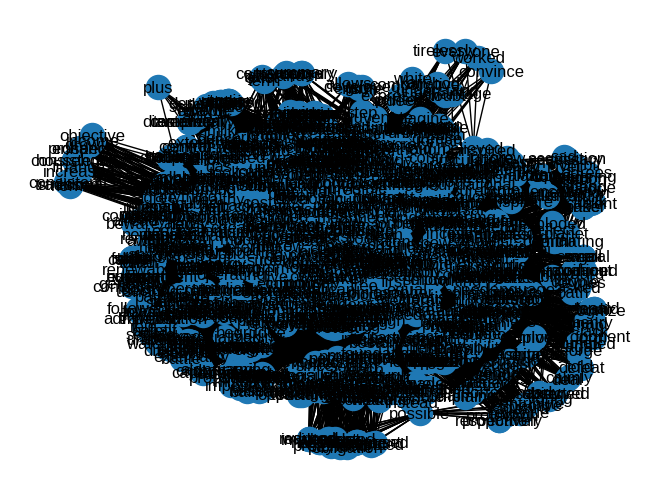

In [10]:
G = nx.Graph()
nodes = [i[0] for j in corpus for i in j]
G.add_nodes_from(nodes)
[G.add_edge(i[0],i[1]) for i in y]
for word_id in nodes:
  G.nodes[word_id]['label'] = dictionary.get(word_id)
labels = {}
for node, data in G.nodes(data=True):
  labels[node] = data.get('label')
nx.draw(G, with_labels=True, labels = labels)
G.nodes(data=True)
degrees = [len(list(G.neighbors(n))) for n in G.nodes()]
print(sorted(degrees, reverse=True))

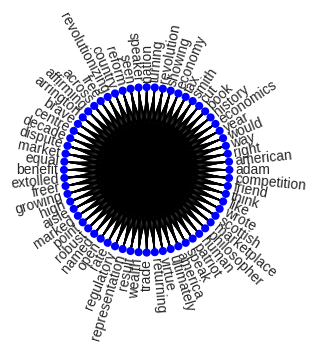

In [15]:
from nxviz import annotate
largest_clique = sorted(nx.find_cliques(G), key=lambda x:len(x))[-1]
G_lc = G.subgraph(largest_clique)
c = nv.circos(G_lc)
labels = {}
for node, data in G_lc.nodes(data=True):
  labels[node] = data.get('label')
G_lc = nx.relabel_nodes(G_lc, labels)
annotate.circos_labels(G_lc, layout="rotate")
plt.tight_layout(rect=(0.15, 0.15, 0.85, 0.85))
plt.show()

In [ ]:
def word_count_desc(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id] += word_count
  sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)
  return sorted_word_count

sorted_word_count = word_count_desc(corpus)
print(sorted_word_count[:10])

In [ ]:
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

In [ ]:
def calculate_weight_of_words(corpus):
  try:
    tfidf = TfidfModel(corpus)
    all_tfidf_weights = []
    i=1
    while tfidf[corpus[i]]:
      tfidf_weights = tfidf[corpus[i]]
      sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
      all_tfidf_weights.append(sorted_tfidf_weights)
      i+=1
    return all_tfidf_weights
  except IndexError:
    return all_tfidf_weights

all_tfidf_weights = calculate_weight_of_words(corpus)
for term_id, weight in all_tfidf_weights[1][:20]:
  print(dictionary.get(term_id), weight)

In [ ]:
def add_extract_length(df):
  df['Extract length'] = df['Extract'].str.len()
  return df
df = add_extract_length(df)
display(df.head())

In [ ]:
def check_sentiment(df):
  polarity = []
  subjectivity = []
  for index, row in df.iterrows():
    sentiment = TextBlob(row['Extract'])
    polarity.append(sentiment.polarity)
    subjectivity.append(sentiment.subjectivity)
  df['Polarity'] = polarity
  df['Subjectivity'] = subjectivity
  return df

df_sentiments = check_sentiment(df)
display(df_sentiments.head())

In [ ]:
def word_cloud(df):
  text = " "
  for index, row in df.iterrows():
    text += " "
    text += row['Extract']
  word_cloud = WordCloud(background_color='white').generate(text)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
word_cloud(df)

In [ ]:
def bow_with_ngrams(df):
  my_stop_words = list(ENGLISH_STOP_WORDS.union(['adam', 'smith', 'speaker', 'don', 'seen', 'smith' 'wrote', 'actually', 'mr speaker', 'sure', 'said']))
  vect = CountVectorizer(ngram_range=(1, 2), max_features=200, stop_words=my_stop_words)
  vect.fit(df.Extract)
  X_extract = vect.transform(df.Extract)
  X_df=pd.DataFrame(X_extract.toarray(), columns=vect.get_feature_names_out())
  return X_df
display(bow_with_ngrams(df).columns)
bow_bigrams = bow_with_ngrams(df).head()
print(bow_bigrams)